In [1]:
# imports
import rosbags_converter as rc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seatrac_enums import CST_E
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress

In [18]:
# User Variables

vehicle = '/coug2'
ROSBAGS_DIR = "/home/bjm255/couguv/CoUGARs/bag" + vehicle 
ROSBAGS_DIR = "/home/bjm255/couguv/CoUGARs/bag" + '/sim' 
SAVES_DIR = "coug2"

MISSION_KEYWORDS = ["Heading"]

VERBOSE=True

In [19]:
# Convert Rosbags
dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS, verbose=True)
if len(dataframes)==0:
    print("converting rosbags")
    typestore = rc.generate_typestore("../../cougars-ros2/src")
    dataframes = rc.convert_rosbags(ROSBAGS_DIR, typestore, 
                                    keywords=MISSION_KEYWORDS,verbose=VERBOSE)
    rc.save_to_csv(dataframes, SAVES_DIR, verbose=VERBOSE)
    dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS)

Loading /home/bjm255/couguv/CoUGARs/cougars-base-station/postprocessing/coug2/converted__Heading_response_faster2.0-2025-05-13-12-28-22


In [20]:
# display topics by rosbag
for path, topics in dataframes.items():
    print(f"{path}:\n\t{list(topics.keys())}")

converted__Heading_response_faster2.0-2025-05-13-12-28-22:
	['/coug2/desired_depth', '/holoocean/auv0/DepthSensor', '/coug2/depth_data', '/clock', '/coug2/dvl/data', '/tf_static', '/holoocean/auv0/DynamicsSensorOdom', '/coug2/desired_heading', '/holoocean/auv0/GPSSensor', '/coug2/controls/debug', '/coug2/desired_speed', '/coug2/extended_fix', '/holoocean/auv0/DVLSensorVelocity', '/holoocean/auv0/LocationSensor', '/coug2/gps_odom', '/coug2/pressure/data', '/coug2/controls/command', '/coug2/modem_imu', '/holoocean/auv0/RotationSensor', '/holoocean/auv0/DynamicsSensorIMU', '/holoocean/auv0/IMUSensor']


In [21]:
# lists dataframes by topic. 
# Assumes all vehicles have only one loaded mission and different namespaces
# Check previous cell output to confirm this is the case
dfsByTopic = {}
for topic_dfs in dataframes.values(): dfsByTopic.update(topic_dfs)
print(list(dfsByTopic.keys()))

['/coug2/desired_depth', '/holoocean/auv0/DepthSensor', '/coug2/depth_data', '/clock', '/coug2/dvl/data', '/tf_static', '/holoocean/auv0/DynamicsSensorOdom', '/coug2/desired_heading', '/holoocean/auv0/GPSSensor', '/coug2/controls/debug', '/coug2/desired_speed', '/coug2/extended_fix', '/holoocean/auv0/DVLSensorVelocity', '/holoocean/auv0/LocationSensor', '/coug2/gps_odom', '/coug2/pressure/data', '/coug2/controls/command', '/coug2/modem_imu', '/holoocean/auv0/RotationSensor', '/holoocean/auv0/DynamicsSensorIMU', '/holoocean/auv0/IMUSensor']


In [22]:
# Display a dataframe
print(f"DataFrame example:")
sampleDf = dfsByTopic[vehicle + "/controls/debug"]
print(sampleDf.iloc[:5])
print("...")

DataFrame example:
   header.stamp.sec  header.stamp.nanosec  header.frame_id  depth.actual  \
0        1747160904             844281284              NaN      0.008402   
1        1747160904             924387642              NaN      0.000845   
2        1747160905               4280924              NaN      0.002087   
3        1747160905              84338009              NaN      0.001038   
4        1747160905             164491951              NaN      0.017037   

   depth.rate  depth.desired  depth.reference   depth.p  depth.i  depth.d  \
0         0.0            0.0         0.143100  2.693965      0.0      0.0   
1         0.0            0.0         0.139706  2.777228      0.0      0.0   
2         0.0            0.0         0.136393  2.686119      0.0      0.0   
3         0.0            0.0         0.133159  2.642415      0.0      0.0   
4         0.0            0.0         0.130001  2.259286      0.0      0.0   

   ...   pitch.d  pitch.pid  heading.actual  heading.rate  he

In [23]:
# convert ros timestamps to pandas timestamps

for df in dfsByTopic.values():
    if "header.stamp.sec" in df.columns: 
        df["timestamp"] = pd.to_datetime(
            df["header.stamp.sec"] * 1_000_000_000 
            + df["header.stamp.nanosec"], unit='ns'
        )

bst_timestamps = dfsByTopic[vehicle + "/desired_depth"]["timestamp"]
print(f"RosBag timeframe:\t{bst_timestamps.min()} --- {bst_timestamps.max()}")

RosBag timeframe:	2025-05-13 18:28:25.030720759 --- 2025-05-13 18:29:32.530266690


/tmp/ipykernel_574936/724313254.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_df["time_sec"] = (cropped_df["timestamp"] - start_time).dt.total_seconds()


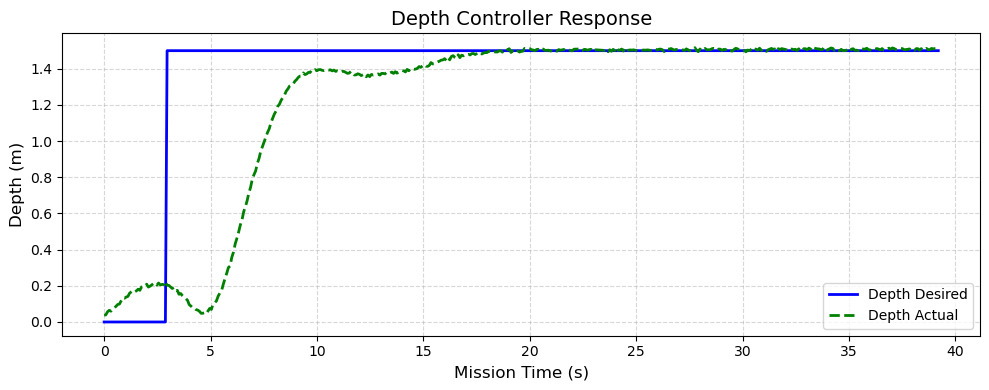

In [25]:

controls_debug = dfsByTopic[vehicle + "/controls/debug"]
cropped_df = controls_debug.iloc[10:501]

# Convert timestamp to seconds since mission start
start_time = cropped_df["timestamp"].iloc[0]
cropped_df["time_sec"] = (cropped_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x = cropped_df["time_sec"].to_numpy()
y1 = cropped_df["depth.desired"].to_numpy()
y2 = cropped_df["depth.actual"].to_numpy()
y3 = cropped_df["depth.reference"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(x, y1, label='Depth Desired', color='blue', linewidth=2)
ax.plot(x, y2, label='Depth Actual', color='green', linewidth=2, linestyle='--')
# ax.plot(x, y3, label='Depth Reference', color='red', linewidth=2, linestyle='--')

# Labels and formatting
ax.set_title('Depth Controller Response', fontsize=14)
ax.set_xlabel('Mission Time (s)', fontsize=12)
ax.set_ylabel('Depth (m)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


/tmp/ipykernel_574936/2385689807.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_df["time_sec"] = (cropped_df["timestamp"] - start_time).dt.total_seconds()


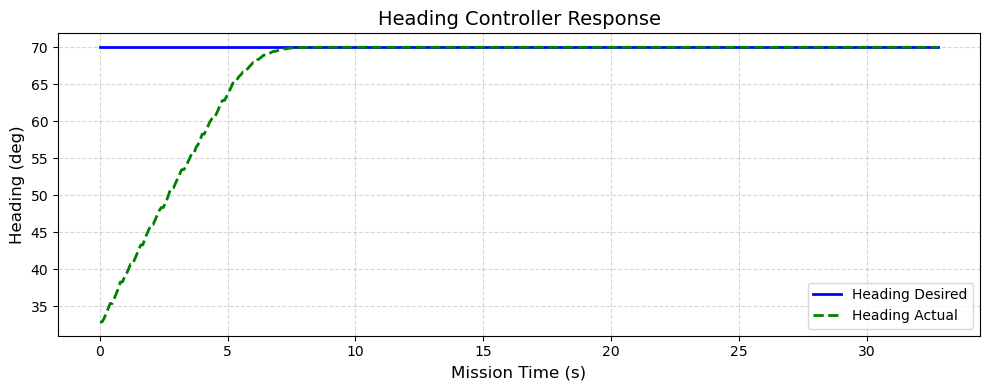

In [28]:

controls_debug = dfsByTopic[vehicle + "/controls/debug"]
cropped_df = controls_debug.iloc[90:501]

# Convert timestamp to seconds since mission start
start_time = cropped_df["timestamp"].iloc[0]
cropped_df["time_sec"] = (cropped_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x = cropped_df["time_sec"].to_numpy()
y1 = cropped_df["heading.desired"].to_numpy()
y2 = cropped_df["heading.actual"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(x, y1, label='Heading Desired', color='blue', linewidth=2)
ax.plot(x, y2, label='Heading Actual', color='green', linewidth=2, linestyle='--')

# Labels and formatting
ax.set_title('Heading Controller Response', fontsize=14)
ax.set_xlabel('Mission Time (s)', fontsize=12)
ax.set_ylabel('Heading (deg)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()
